![image.png](https://i.imgur.com/a3uAqnb.png)

# **🚀 Exercise: Build a Smoking Detection Classifier**
In this exercise, you will **train a binary classifier** to detect whether a person is **smoking** or **not smoking** using the `Smoking` dataset.

✅ **You will:**

1️⃣ Download the dataset.  
2️⃣ Build a **custom Dataset class** to handle image loading.  
3️⃣ Use **ResNet-18** as a pretrained model (can be accessed via: from torchvision.models import resnet18).  
4️⃣ Train the model and report **Training, Validation, and Testing Accuracy**.  
5️⃣ Display some **predictions along with images** at the end.  

In [ ]:
# # Please uncomment this out when you are running this lab on google colab!
# import os

# # Set KaggleHub cache to a directory inside /content/
# os.environ["KAGGLEHUB_CACHE"] = "/content/data"

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sujaykapadnis/smoking")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/smoking


## 1️⃣ Dataset Class

In [ ]:
import os
import glob
from tqdm import tqdm

# Define dataset path
dataset_path = os.path.join(path, "Training", "Training")
# Get all image paths
train_image_paths = glob.glob(f"{dataset_path}/*.jpg")

# Define dataset path
dataset_path = os.path.join(path, "Validation", "Validation")
# Get all image paths
valid_image_paths = glob.glob(f"{dataset_path}/*.jpg")

# Define dataset path
dataset_path = os.path.join(path, "Testing", "Testing")
# Get all image paths
test_image_paths = glob.glob(f"{dataset_path}/*.jpg")


train_labels = []
valid_labels = []
test_labels = []

for path in tqdm(train_image_paths):
    prefix  = path.split("/")[-1].split("_")[0]                 # "./Training/smoking_0007.jpg" → "smoking_0007.jpg"  → "smoking"
    label = 1 if prefix == "smoking" else 0                     # Assign label
    train_labels.append(label)                                  # Store label

for path in tqdm(valid_image_paths):
    prefix = path.split("/")[-1].split("_")[0]
    label = 1 if prefix == "smoking" else 0
    valid_labels.append(label)

for path in tqdm(test_image_paths):
    prefix = path.split("/")[-1].split("_")[0]
    label = 1 if prefix == "smoking" else 0
    test_labels.append(label)

100%|██████████| 224/224 [00:00<00:00, 528713.62it/s]


In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class SmokingDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths  # List of image paths
        self.labels = labels  # Corresponding labels
        self.transform = transform  # Transformations to apply

    def __len__(self):
        return len(self.image_paths)  # Total number of images

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]  # Get image path
        label = self.labels[idx]  # Get corresponding label

        # Load image
        image = Image.open(image_path)

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, label  # Return processed image and its label

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


transform_valid_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize datasets
train_dataset = SmokingDataset(train_image_paths, train_labels, transform=transform)
valid_dataset = SmokingDataset(valid_image_paths, valid_labels, transform=transform_valid_test)
test_dataset = SmokingDataset(test_image_paths, test_labels, transform=transform_valid_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get a batch of training images
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels}")

Batch shape: torch.Size([32, 3, 224, 224]), Labels: tensor([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 1])


## 2️⃣ Model Class

In [ ]:
from torchvision import models
from torch import nn

# Load pretrained resnet18
model = models.resnet18(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

###

Looking at the **ResNet architecture**, we can see that the **last fully connected (fc) layer** is designed for **1000 classes** (ImageNet classification).  
Since we are working on **binary classification** (Smoking vs. NoSmoking), we need to **replace the last layer** with a new one that outputs **a single value**.


To modify the last layer, we need to know how many input features it expects.  
We can access this using:
```python
model.fc.in_features

In [ ]:
import torch

# Replace the head
model.fc = nn.Linear(model.fc.in_features, 1)  # 2 classes

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 3️⃣ Training and Validation Loops

In [ ]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device, torch.float)


        outputs = model(images).squeeze()  # The model outputs in shape [batch_size,1]. We convert them to [batch_size,] so the loss accepts them.
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Track accuracy
        predictions = torch.sigmoid(outputs) > 0.5  # Get predicted class
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device, torch.float)

            outputs = model(images).squeeze()  # The model outputs in shape [batch_size,1]. We convert them to [batch_size,] so the loss accepts them.
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Compute accuracy
            predictions = torch.sigmoid(outputs) > 0.5  # Get predicted class
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


## 4️⃣ Running Training

In [ ]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Classification loss (Use when there is no softmax/sigmoid in the last layer)
optimizer = optim.AdamW(model.parameters(), lr=0.001)  # AdamW optimizer
num_epochs = 10 # Number of epochs


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, valid_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")


100%|██████████| 23/23 [00:08<00:00,  2.66it/s]


Epoch 1/10: Train Loss=0.6881, Train Accuracy=71.79%, Val Loss=1.4474, Val Accuracy=53.33%


100%|██████████| 23/23 [00:05<00:00,  4.48it/s]


Epoch 2/10: Train Loss=0.4167, Train Accuracy=81.42%, Val Loss=0.4185, Val Accuracy=85.00%


100%|██████████| 23/23 [00:04<00:00,  4.78it/s]


Epoch 3/10: Train Loss=0.3106, Train Accuracy=86.17%, Val Loss=0.3900, Val Accuracy=81.67%


100%|██████████| 23/23 [00:04<00:00,  4.86it/s]


Epoch 4/10: Train Loss=0.2386, Train Accuracy=89.39%, Val Loss=0.3620, Val Accuracy=88.33%


100%|██████████| 23/23 [00:04<00:00,  4.99it/s]


Epoch 5/10: Train Loss=0.2305, Train Accuracy=90.08%, Val Loss=0.8350, Val Accuracy=77.22%


100%|██████████| 23/23 [00:04<00:00,  5.04it/s]


Epoch 6/10: Train Loss=0.2436, Train Accuracy=89.94%, Val Loss=0.3332, Val Accuracy=88.33%


100%|██████████| 23/23 [00:04<00:00,  4.93it/s]


Epoch 7/10: Train Loss=0.2173, Train Accuracy=92.18%, Val Loss=0.4206, Val Accuracy=83.89%


100%|██████████| 23/23 [00:04<00:00,  4.85it/s]


Epoch 8/10: Train Loss=0.1925, Train Accuracy=90.92%, Val Loss=0.4560, Val Accuracy=83.33%


100%|██████████| 23/23 [00:04<00:00,  5.02it/s]


Epoch 9/10: Train Loss=0.1030, Train Accuracy=96.09%, Val Loss=0.4683, Val Accuracy=85.56%


100%|██████████| 23/23 [00:04<00:00,  5.04it/s]


Epoch 10/10: Train Loss=0.1011, Train Accuracy=96.37%, Val Loss=0.9639, Val Accuracy=73.89%


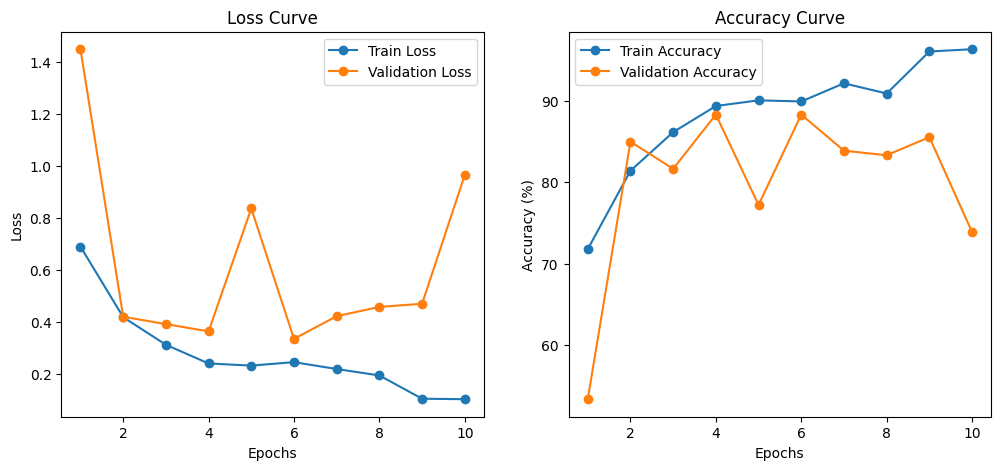

In [ ]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()
